# The Land Change Monitoring, Assessment, and Projection (LCMAP) data direct access

## This code was adapted from USGS LCMAP direct access python code ( https://code.usgs.gov/lcmap/1a_lcmap_direct_access) to directly download user defined mosaiced LCMAP product for any region of interest. In addition to accessing the row data, the below website provides additional resources on further processing of data including quality filtering, masking, and reprojection.

### (https://www.usgs.gov/special-topics/lcmap/tutorials) 

In [31]:
# Import Packages
import rasterio as rio
import rasterio.mask
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import matplotlib.colors as clr
import matplotlib.patches as mpatches
import numpy as np
import time
import os
import warnings
warnings.filterwarnings("ignore")

In [32]:
b_url = "https://edcintl.cr.usgs.gov/downloads/sciweb1/shared/lcmap/public/full_extent_downloads/"  # Base URL for LCMAP data

In [33]:
roi_path = "./Data/SR_prj.shp"  #4 Define the ROI used to extract a subset of LCMAP data

In [34]:
# Region shortname and longname
region_dict = {'CU': 'conus',
               'HI': 'hawaii'}

# Available versions by region
rv_dict = {'CU':['version_13', 'V13'],
           'HI': ['version_10', 'V10']}

# Product shortname and longname
prod_dict = {'LCPRI': 'primary-landcover',
             'LCSEC': 'secondary-landcover',
             'LCPCONF': 'primary-confidence',
             'LCSCONF': 'secondary-confidence',
             'LCACHG': 'cover-change',
             'SCTIME': 'change-day',
             'SCMAG': 'change-magnitude',
             'SCLAST': 'spectral-lastchange',
             'SCSTAB': 'spectral-stability',
             'SCMQA': 'model-quality'}

In [35]:
# Inputs: Define the desired Region, Product, and Year
region = 'CU'      #1 or HI for Hawaii
product = 'LCPRI'  #2 See LUT above for additional products
year = '1985'      #3 1985-2021 available for CONUS, 2000-2020 available for HI

In [36]:
# Construct the URL in two parts for readability
prod_url = f"LCMAP_{region}_{year}_{rv_dict[region][1]}_{product}"
print(prod_url)

LCMAP_CU_1985_V13_LCPRI


In [37]:
url = f"{b_url}{rv_dict[region][0]}/{prod_dict[product]}_{region_dict[region]}_year_data/{prod_url}/{prod_url}.tif"
print(url)

https://edcintl.cr.usgs.gov/downloads/sciweb1/shared/lcmap/public/full_extent_downloads/version_13/primary-landcover_conus_year_data/LCMAP_CU_1985_V13_LCPRI/LCMAP_CU_1985_V13_LCPRI.tif


In [39]:
lcmap.crs.to_proj4()

'+proj=aea +lat_0=23 +lon_0=-96 +lat_1=29.5 +lat_2=45.5 +x_0=0 +y_0=0 +ellps=IAU76 +units=m +no_defs=True'

In [40]:
color = lcmap.colormap(1)

In [41]:
ROI = gpd.read_file(roi_path)
ROI

,NA_L3CODE,NA_L3NAME,NA_L2CODE,NA_L2NAME,NA_L1CODE,NA_L1NAME,NA_L3KEY,NA_L2KEY,NA_L1KEY,Shape_Leng,Shape_Area,geometry
0,6.2.14,Southern Rockies,6.2,WESTERN CORDILLERA,6,NORTHWESTERN FORESTED MOUNTAINS,6.2.14 Southern Rockies,6.2 WESTERN CORDILLERA,6 NORTHWESTERN FORESTED MOUNTAINS,5.411523e+06,1.443493e+11,"POLYGON ((-106.37415 42.77021, -106.37074 42.7..."


In [42]:
lcmap.crs.to_proj4()  # Print out LCMAP Projection

'+proj=aea +lat_0=23 +lon_0=-96 +lat_1=29.5 +lat_2=45.5 +x_0=0 +y_0=0 +ellps=IAU76 +units=m +no_defs=True'

In [43]:
ROI.crs.to_proj4()  # Print out ROI Projection

'+proj=longlat +datum=WGS84 +no_defs +type=crs'

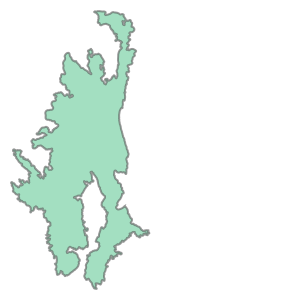

In [44]:
# ROI_reproj = ROI.to_crs(lcmap.crs)['geometry'][6]  # Reproject geometry to match source projection
# ROI_reproj

ROI_reproj = ROI.to_crs(lcmap.crs)['geometry'][0]  # Reproject geometry to match source projection
ROI_reproj

In [45]:
%%time
lcmap_data, lcmap_transform = rio.mask.mask(lcmap, [ROI_reproj], crop=True)

CPU times: total: 8.83 s
Wall time: 35.2 s


In [46]:
lcmap_data.shape

(1, 28058, 13960)

In [47]:
lcmap_transform

Affine(30.0, 0.0, -1111935.0,
       0.0, -30.0, 2243355.0)

In [48]:
values, counts = np.unique(lcmap_data, return_counts=True)

In [49]:
# Create a LUT of LCPRI values and long names
class_dict = {0: 'No Data', 
              1: 'Developed', 
              2: 'Cropland', 
              3: 'Grass/Shrub', 
              4: 'Tree Cover', 
              5: 'Water', 
              6: 'Wetland', 
              7: 'Ice/Snow', 
              8: 'Barren'}

count_dict = dict([(class_dict[v],c) for v,c in zip(values, counts) if v != 0])  # Define dictionary of counts by LCPRI value
count_dict

{'Developed': 879410,
 'Cropland': 2004915,
 'Grass/Shrub': 53313796,
 'Tree Cover': 95270598,
 'Water': 581209,
 'Wetland': 2973926,
 'Ice/Snow': 1248642,
 'Barren': 4240749}

In [50]:
roi_name = 'SR_EPA_III'  # Define a title for the visualizations

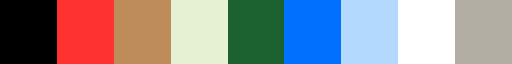

In [51]:
color_ramp = ['#%02x%02x%02x' % color[c][:3] for c in color][:9]                      # Convert rgb to hex
cmap = clr.LinearSegmentedColormap.from_list('LCPRI', color_ramp, N=len(color_ramp))  # Create a custom color ramp
cmap.set_bad('#000000')                                                               # Set bad (masked or no data) to black
cmap

In [52]:
out_file_name = f"{roi_name.replace(' ', '_').replace(',','')}_{prod_url}.tif"  # Remove any spaces or commas from roi_name

# Create output directory
out_dir = './SR/'
os.makedirs(out_dir, exist_ok=True)
out_file_path = os.path.join(out_dir, out_file_name)

In [53]:
meta = lcmap.meta
meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 160000,
 'height': 105000,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.256999999996,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(30.0, 0.0, -2415585.0,
        0.0, -30.0, 3314805.0)}

In [54]:
# Use the lcmap_data array to define the updated width and height, and use the geotransform provided from rasterio.mask()
meta.update({'width': lcmap_data.shape[2],
             'height': lcmap_data.shape[1],
             'transform': lcmap_transform})

In [55]:
with rio.open(out_file_path, 'w', **meta, compress='lzw', tiled=True, blockxsize=256, blockysize=256) as out_file:
    out_file.write(lcmap_data)
    out_file.write_colormap(1, color)    

In [56]:
# Close the LCMAP Mosaic
lcmap.close()
del lcmap

In [57]:
years = np.arange(1985, 2022, 1) 

In [58]:
# %%time

# with open(out_csv, "w") as f:
#     f.write(','.join(headers)+'\n')
    
developed = []
for year in years:
    
    # Construct URL
    prod_url = f"LCMAP_{region}_{year}_{rv_dict[region][1]}_{product}"
    url = f"{b_url}{rv_dict[region][0]}/{prod_dict[product]}_{region_dict[region]}_year_data/{prod_url}/{prod_url}.tif"
    
    # Open and extract data
    with rio.open(url) as lcmap:
        lcmap_data, lcmap_transform = rio.mask.mask(lcmap, [ROI_reproj], crop=True)
        meta = lcmap.meta
    
    # Perform analysis
    values, counts = np.unique(lcmap_data, return_counts=True)
    count_dict = dict([(class_dict[v],c) for v,c in zip(values, counts) if v != 0])
    area = '{:.2f}'.format(count_dict['Tree Cover']* (30*30) / 1000000)
    percent = '{:.2f}'.format(count_dict['Tree Cover'] / sum(count_dict.values()) * 100)
    #print(f"{roi_name} had {area} sq. km of Tree Cover ({percent}%) in {year}.") 
    print(f"{year} ,{area} ,{percent}") 
    developed.append(count_dict['Tree Cover'] * (30*30) / 1000000)

    developed
    
    # Update Metadata, Create filename, and Export subset as GeoTIFF
    meta.update({'width': lcmap_data.shape[2], 'height': lcmap_data.shape[1], 'transform': lcmap_transform})
    out_file_name = f"{roi_name.replace(' ', '_').replace(',','')}_{prod_url}.tif"
    out_file_path = os.path.join(out_dir, out_file_name)
    with rio.open(out_file_path, 'w', **meta, compress='lzw', tiled=True, blockxsize=256, blockysize=256) as out_file:
        out_file.write(lcmap_data)
        out_file.write_colormap(1, color)        

1985 ,85743.54 ,59.35
1986 ,85771.53 ,59.37
1987 ,85743.60 ,59.35
1988 ,85661.78 ,59.30
1989 ,85571.81 ,59.23
1990 ,85556.21 ,59.22
1991 ,85584.56 ,59.24
1992 ,85625.06 ,59.27
1993 ,85654.49 ,59.29
1994 ,85668.69 ,59.30
1995 ,85783.70 ,59.38
1996 ,85735.26 ,59.35
1997 ,85731.77 ,59.35
1998 ,85709.20 ,59.33
1999 ,85692.38 ,59.32
2000 ,85520.96 ,59.20
2001 ,85476.41 ,59.17
2002 ,84848.52 ,58.73
2003 ,84826.19 ,58.72
2004 ,84875.36 ,58.75
2005 ,84878.43 ,58.75
2006 ,84677.36 ,58.62
2007 ,84611.79 ,58.57
2008 ,84533.86 ,58.52
2009 ,84461.15 ,58.47
2010 ,84361.62 ,58.40
2011 ,84216.03 ,58.30
2012 ,83912.70 ,58.09
2013 ,83587.02 ,57.86
2014 ,83495.72 ,57.80
2015 ,83470.82 ,57.78
2016 ,83318.47 ,57.68
2017 ,83112.07 ,57.53
2018 ,82728.50 ,57.27
2019 ,82389.55 ,57.03
2020 ,82188.90 ,56.89
2021 ,81245.63 ,56.24
